# 最尤推定

尤度を最大化するパラメータを求める．  
あるパラメータ$\theta$に従う確率分布からデータ$x$が得られる確率$P(x|\theta)$を最大化する$\theta$を求める．  

$$
\argmax_{\theta} \, P(x|\theta)
$$

In [1]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt


---

## 総当たりで求める

$\theta$の値を全て試して求める．

参考
- [最尤推定量とは？初めての人にもわかる解説 | AVILEN AI Trend](https://ai-trend.jp/basic-study/estimator/maximum-likelihood-estimation/)

<br>

以下の問題を例題として考える

> 箱の中に10個の玉がある．玉の色は赤か白のいずれかである．  
箱の中からランダムに玉を取り出し，色を確認してから戻す．これを10回繰り返した．  
その結果，赤玉が3回，白玉が7回出てきた．さあ，箱の中には赤玉が何個あるだろうか．

では解いていく．

$x$を赤が出た回数とすると，$x$は二項分布に従う．二項分布の確率密度関数は以下．  

$$
\mathrm{bin}(x; n, p) = {}_n C_x p^x (1-p)^{n-x}
$$


二項分布のパラメータは試行回数$n$と確率$p$で，今回の場合$n=10$が確定しており，$p$が推定したいパラメータとなる．  
$p$は箱の中に入っている赤玉の割合を表すので，これに$n=10$をかければ赤玉の数が推定できる．

<br>

最尤推定ではまず尤度関数を設定する．これは，あるパラメータ$\theta$の下であるデータ$x$が得られる確率を返す，$\theta$についての関数である．  
今回の場合は以下の様になる．

$$
\mathrm{L}(\theta|x) = \mathrm{bin}(x; n, \theta) = {}_n C_x \theta^x (1-\theta)^{n-x}
$$

すると，最尤推定で求めたいものは以下の様に表せる．

$$
\argmax_{\theta} \, \mathrm{L}(\theta|x)
$$

これを総当たりで求める．この問題において，$\theta$は以下の11通りである．

In [2]:
theta = torch.arange(0, 10 + 1) / 10
theta

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])

これら一つ一つで尤度を計算して，最大値を取った$\theta$を求める．

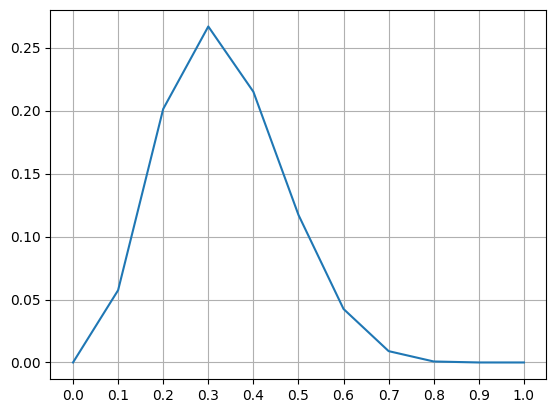

In [3]:
x = torch.tensor(3) # 実測値
n = 10 # 試行回数

binomal = dist.Binomial(n, theta) # 試行回数10, 確率psの二項分布
probs = binomal.log_prob(x).exp() # 分布から3が得られる確率
plt.plot(theta, probs)
plt.xticks(theta)
plt.grid();

$\theta = 0.3$が最も大きくなった．この$\theta$は**最尤推定量**と呼ぶ．  
以上より，箱の中には赤玉が$n \times \theta = 3$個あると推定できる．


---

## 解析的に求める

先ほどは$\theta$が離散値で且つ選択肢も少なかったので総当たりで求められたが，選択肢が多い場合やそもそも連続値の場合，総当たりには限界がある．  
そこで，解析的に（計算で）求める手法を考える．

やり方は簡単で，尤度関数を$\theta$について微分して，傾きが0になる$\theta$を求めるだけ．

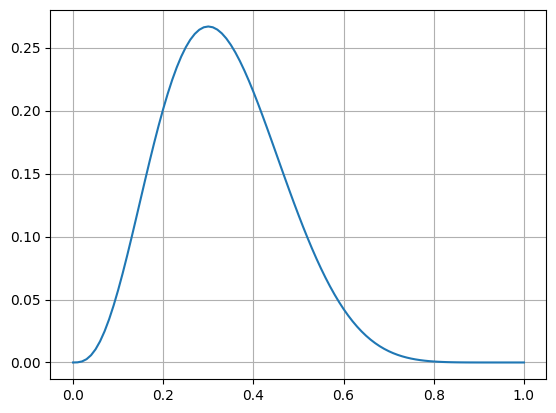

In [4]:
p = torch.arange(0, 1 + 0.01, 0.01)
binomal = dist.Binomial(10, p)
log_likelihood = binomal.log_prob(x) # 対数尤度
likelihood = log_likelihood.exp() # 尤度
plt.plot(p, likelihood)
plt.grid();

これを微分する．

ここで

$$
L(\theta|x) = {}_n C_x \theta^x (1-\theta)^{n-x}
$$

は微分が面倒臭い．そこで，対数をとった関数

$$
\log \, L(\theta|x)
$$

を考える．

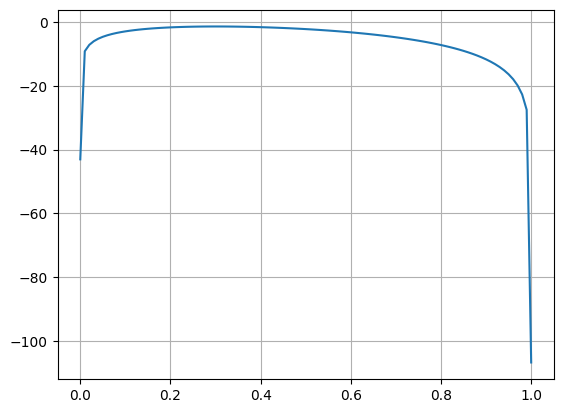

In [5]:
plt.plot(p, log_likelihood)
plt.grid();

こうすると微分が簡単になる．これは対数尤度関数と呼ぶ．  
$\argmax_x x = \argmax_x \log x$が成り立つので，対数尤度関数を最大化する$\theta$を求めればよい．


<br>

実際に計算してみる．まず対数尤度関数を変形する．

$$
\begin{align}
    \mathrm{log} \, L(\theta|x)
        &= \mathrm{log} \, \left( {}_n C_x \theta^x (1-\theta)^{n-x} \right) \\
        &= \mathrm{log} \, {}_n C_x + x \mathrm{log} \, \theta + (n-x) \mathrm{log} \, (1-\theta) \\ 
\end{align}
$$

次にこれを$\theta$で微分する

$$
\begin{align}
    \frac{\mathrm{d}}{\mathrm{d} \theta} \mathrm{log} \, L(\theta|x)
        &= 0 + \frac{x}{\theta} - \frac{n-x}{1-\theta} \\
        &= \frac{x(1-\theta) - (n-x)\theta}{\theta(1-\theta)} \\
        &= \frac{x - \theta n}{\theta(1-\theta)} \\
\end{align}
$$

最後にこれが0になる$\theta$を求める

$$
\begin{align}
    \frac{x - \theta n}{\theta(1-\theta)} &= 0 \\
    x - \theta n &= 0 \\
    \theta n &= x \\
    \theta &= \frac{x}{n} \\
\end{align}
$$

$n=10, x=3$より，$\theta = \frac{3}{10} = 0.3$が最尤推定量となる．


---

## EMアルゴリズム

解析的な求め方ができない場合に役立つ手法．

<br>

先ほどの問題は二項分布という簡単な分布を用いたが，複雑な分布だと解析的に求めることも難しくなる．

例えば，以下の分布を考える．

$$
z \sim \mathrm{Bernoulli}(\theta) \\
x \sim \begin{cases}
    \mathrm{Normal}(0, 1) & (z=0) \\
    \mathrm{Normal}(5, 1) & (z=1)
\end{cases}
$$

$\theta$を0.7にしてサンプリングしてみる．

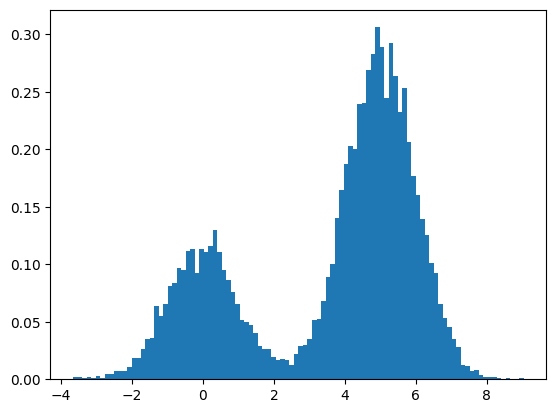

In [6]:
theta = 0.7
n = 10000

ber = dist.Bernoulli(theta)
norm0 = dist.Normal(0, 1)
norm1 = dist.Normal(5, 1)
def sampling(n):
    x = []
    for _ in range(n):
        z = ber.sample()
        if z == 0:
            x.append(norm0.sample())
        else:
            x.append(norm1.sample())
    return torch.tensor(x)

x = sampling(n)
plt.hist(x, bins=100, density=True);

このデータから$\theta$を予測する．

参考
- [EMアルゴリズムとともだちになろう | ドクセル](https://www.docswell.com/s/mutopsy/K18DP5-2022-08-16-163818#p17)
- [【徹底解説】EMアルゴリズムをはじめからていねいに | Academaid](https://academ-aid.com/ml/em)

まず尤度関数を考える．

$$
\mathrm{L}(\theta|x) = \prod_{i=1}^n p(x_i; \theta)
$$

次に対数尤度関数を考える．

$$
\begin{align}
    \mathrm{log} \, L(\theta|x)
        &= \mathrm{log} \, \prod_{i=1}^n p(x_i; \theta) \\
        &= \sum_{i=1}^n \log \, p(x_i; \theta) \\
\end{align}
$$

ここで，$p(x_i; \theta)$を周辺化する．

$$
p(x_i; \theta) = \sum_{j=0}^1 p(x_i, z_j; \theta)
$$

でこれを対数尤度関数に当てはめると

$$
\mathrm{log} \, L(\theta|x) = \sum_{i=1}^n \log \, \sum_{j=0}^1 p(x_i, z_j; \theta)
$$

$\log$の中に$\Sigma$が入ってしまった．これは計算が困難．

<br>

この様に，**潜在変数**が絡む分布の場合は$\log$の中に$\Sigma$が入ってしまって計算が困難になる．  
潜在変数とは，観測できない（表面に出てこない）が分布に影響を与える変数のこと．上の式でいうと$z$がそれに当たる．  
潜在変数が絡む分布の代表的な例は混合ガウス分布．こういった分布は尤度を潜在変数で周辺化することで$\log$の中に$\Sigma$が入るため，最尤推定が解析的に行えない．

そんな時に使うのがEMアルゴリズム．

まず周辺対数尤度をグラフにしてみる．

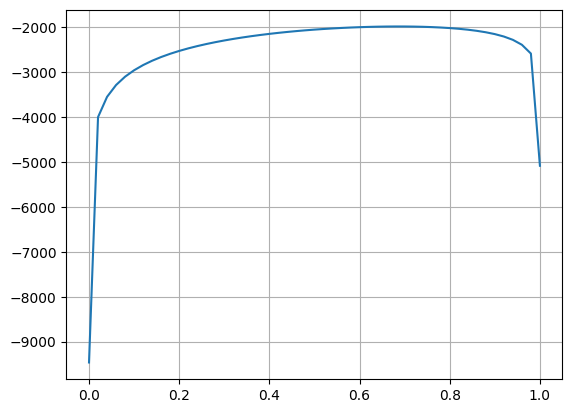

In [7]:
x = sampling(1000)
ps = torch.arange(0, 1 + 0.02, 0.02)

def log_likelihood(x, p):
    ber = dist.Bernoulli(p)
    ll = 0
    for xi in x:
        ll_ = 0
        ll_ += ber.log_prob(torch.tensor(0.)).exp() * norm0.log_prob(xi).exp()
        ll_ += ber.log_prob(torch.tensor(1.)).exp() * norm1.log_prob(xi).exp()
        ll += torch.log(ll_)
    return ll

lls = [log_likelihood(x, p) for p in ps]
plt.plot(ps, lls)
plt.grid();

こんな感じ．最大値も0.7を示してる．

In [8]:
idx = torch.argmax(torch.tensor(lls))
ps[idx]

tensor(0.6800)

（総当たりで求められるじゃんって思うかもしれないけど，$\theta$を0.02刻みで離散化して，サンプル数を1000に減らした上でこの計算時間なので，実用的では無い．）

では式変形をしていこう．  
まず**イェンゼンの不等式**を使って，対数尤度関数の下界を求める．

$$
\begin{align}
    \log L(\theta|x)
        &= \sum_{i=1}^n \log \sum_{j=0}^1 p(x_i, z_j; \theta) \\
        &= \sum_{i=1}^n \log \sum_{j=0}^1 \lambda_{ij} \frac{p(x_i, z_j; \theta)}{\lambda_{ij}} \quad \\
        &\geq \sum_{i=1}^n \sum_{j=0}^1 \lambda_{ij} \log \frac{p(x_i, z_j; \theta)}{\lambda_{ij}} \\
        &= \mathcal{L}(\theta|\lambda)
\end{align}
$$

$\lambda_{ij}$は$\sum_{j=0}^1 \lambda_{ij} = 1$を満たすなんらかの実数．$\mathcal{L}(\theta|\lambda)$が下界．

<br>




$$
\begin{align}
    \mathcal{L}(\theta|\lambda)
        &= \sum_{i=1}^n \sum_{z=0}^1 \lambda_z \log \, \frac{p(x_i, z; \theta)}{\lambda_z} \\
        &= \sum_{i=1}^n \sum_{z=0}^1 p(z_j|x_i; \theta_0) \log \, \frac{p(x_i, z; \theta)}{p(z_j|x_i; \theta_0)} \\
        &= \sum_{i=1}^n \sum_{z=0}^1 p(z_j|x_i; \theta_0) \, \log \, p(x_i, z; \theta) + \mathrm{const} \\
        &= \mathcal{Q}(\theta|\theta_0) + \mathrm{const}
\end{align}
$$

$z$についての期待値になった．

次にこの下界を最大にする$\theta$を求め，それを$\theta_1$とする．

$$
\begin{align}
    \theta_1
        &= \argmax_\theta \, \mathcal{L}(\theta|\lambda) \\
        &= \argmax_\theta \, \mathcal{Q}(\theta|\theta_0) \\
        &= \argmax_\theta \, \sum_{i=1}^n \sum_{z=0}^1 p(z_j|x_i; \theta_0) \, \log \, p(x_i, z; \theta) \\
\end{align}
$$

これは微分すれば簡単に求められるらしい．